<a href="https://colab.research.google.com/github/kenz3wiz/Stats/blob/main/Survival_Prediction_on_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploration of Titanic Data and Prediction of Survival

This notebook will aim to:
1. Assess and explore relationships between the features in the data
2. Create new features from the available ones both in the train and test data
3. Impute missing values with justifiable ones
4. Explore various algorithms(Classifiers)
5. Select the best algorithm to help predict an unseen data(test)
6. Fine tune hyperparameters to create an optimum model
7. Predict survival from the test data

Progressively, libraries will be imported as required

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_train = df_train.drop(columns=["Embarked", "Cabin", "Name", "Ticket"])
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,male,22.0,1,0,7.2500
1,2,1,1,female,38.0,1,0,71.2833
2,3,1,3,female,26.0,0,0,7.9250
3,4,1,1,female,35.0,1,0,53.1000
4,5,0,3,male,35.0,0,0,8.0500


##### **Feature Observations**

Here we will look at the potential of every feature in feature engineering.

**1. _PassengerID_** - does not have any indication to create a new feature from it.

**2. _Survived_** - is a class feature to be predicted with regard to each passengerin the test data thus no feature can be derived from it.

**3. _Pclass_** - is class feature detailing the ticket classification if 1st, 2nd, or 3rd and no feature can be got from it.


**4. _Sex_** - is categorical feature detailing passenger orientation if male or female and no feature can be created from it.

**5. _Age_** - is an ordinal unique feature showing amount of years lived and can create an **AgeGroup** categorical feature.

**6. _SibSp_** - is a feature showing the relationship of either Sibling or Spouse and create a **FamilySize** feature together with the **Parch** feature.

**7. _Parch_** - is a feature showing the relationship of either Parent or Child and can create a **FamilySize** feature together with the **SibSp** feature.

**8. _Ticket_** - is a feature detailing the unique ticket number of each passenger and can be explored to create **T_Prefix** feature.

**9. _Fare_** - is a feature showing the amount paid by each passenger and can help create a **FareGroup** feature.


#### **Initial Exploration**

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
dtypes: float64(2), int64(5), object(1)
memory usage: 55.8+ KB


In [6]:
1 - (df_train.count() / len(df_train))

,0
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Sex,0.000000
Age,0.198653
SibSp,0.000000
Parch,0.000000
Fare,0.000000


**Observations**

1. Age has about 20% missing values which can be imputed with either mean, mode or median
2. Cabin has about 77% missing values and any imputation will give a distribution not representative of actual or close enough.
3. Emabarked has about 0.22% missing values giving an indication of an easy imputation of the missing values
4. All the other features do not have missing values.

In [7]:
df_train.describe(include='all')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891,714.000000,891.000000,891.000000,891.000000
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,male,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,577,NaN,NaN,NaN,NaN
mean,446.000000,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,31.000000


**Observation**

1. Minimum fare is 0 and also seems not normal

#### **Imputation of Age and Embarked Features**

In [8]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

data = df_train[['Survived', 'Pclass', 'Sex','Age', 'SibSp','Parch', 'Fare']]

In [9]:
# Recreating the Sex feature
def sexify(x):
    """
    This function maps the encoded sex feature back to its original values.

    Args:
    x: The encoded sex feature (0 or 1).

    Returns:
    The original sex value ('female' or 'male').
    """
    if x == 0:
        return 'female'
    else:
        return 'male'

# Assuming df_train has a 'Sex' column with 'male' and 'female' values
# Create a new column 'Sex_male' using one-hot encoding
df_train['Sex_male'] = pd.get_dummies(df_train['Sex'], drop_first=True)['male']

# Create df2 (or use an existing DataFrame if applicable)
df2 = df_train.copy()  # For example, creating a copy of df_train

# Now apply the sexify function to the 'Sex_male' column in df2
df2['Sex'] = df_train['Sex_male'].apply(sexify)

In [10]:
# Recreating the Sex feature
df2['Sex'] = df_train['Sex_male'].apply(sexify)

#### **Exploration the Relationship of Features to Survival**

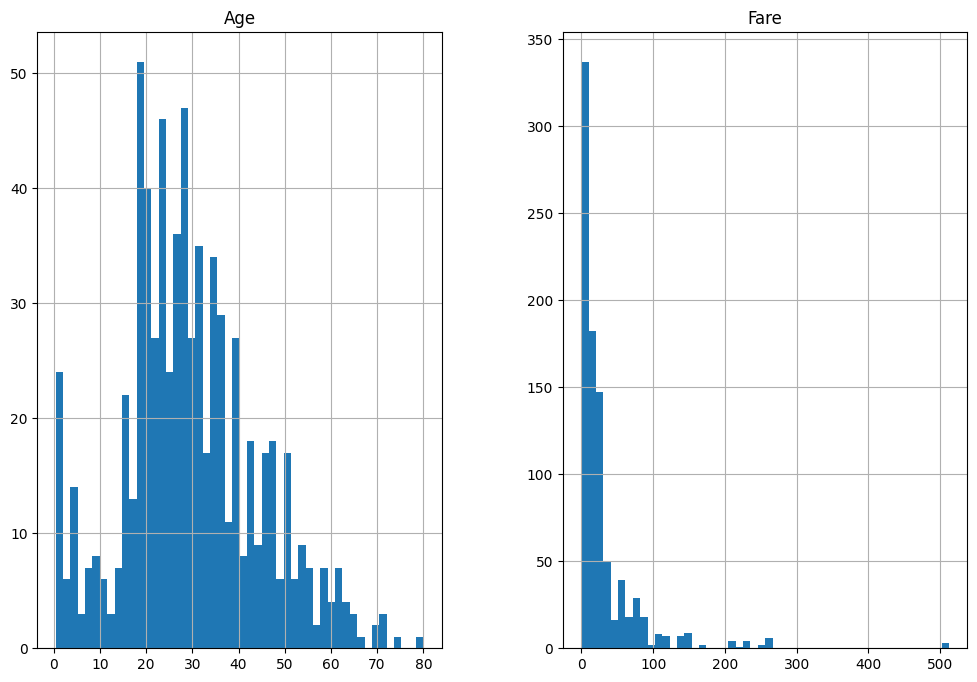

In [11]:
df_train[['Age', 'Fare']].hist(bins=50, figsize=(12, 8))
plt.show()

1. **Sex**

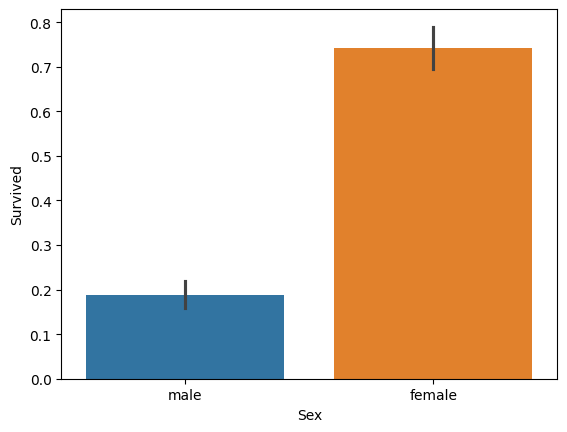

In [12]:
sns.barplot(data=df_train, x='Sex', y='Survived', hue='Sex')
plt.show()

**Observation**

Being a female, there is a likelihood to survive.

2. **Pclass**

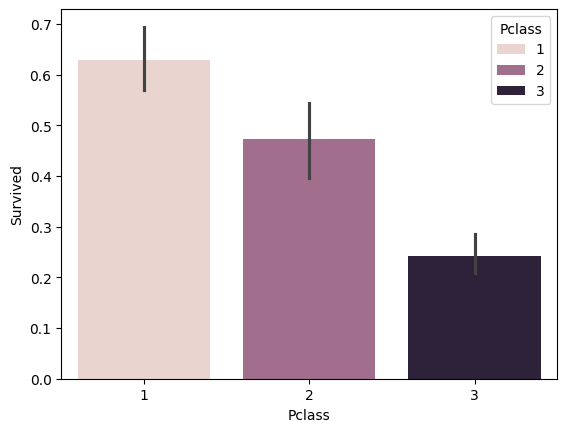

In [13]:
sns.barplot(data=df_train, x= 'Pclass', y='Survived', hue='Pclass')
plt.show()

**Observation**

Passenger class 1 and 2 have a higher likelihood to survive.

3. **Age**

We will create a new class feature - **AgeGroup** which will assist in classification of age and give the general relationship with the **Survival** feature.
Classification will be as follows:

0-5 -> Baby

6-15 -> Child

16-35 -> Youth

36-55 -> Adult

55-80 -> Senior

In [14]:
import numpy as np

bins = [0, 6, 16, 36, 55, np.inf]
labels = ['Baby', 'Child', 'Youth', 'Adult', 'Senior']

df_train['AgeGroup'] = pd.cut(df_train['Age'], bins = bins, labels = labels)

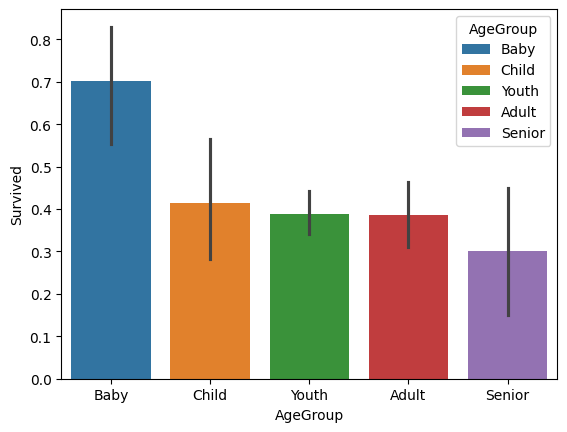

In [15]:
sns.barplot(data=df_train, x='AgeGroup', y='Survived', hue='AgeGroup')
plt.show()

**Observation**

1. Babies have a high likelihood to survive
2. Childrend and Adults have a similar likelihood to survive almost shared with youths
3. Seniors have the lowest survival rate




4. **SibSp**

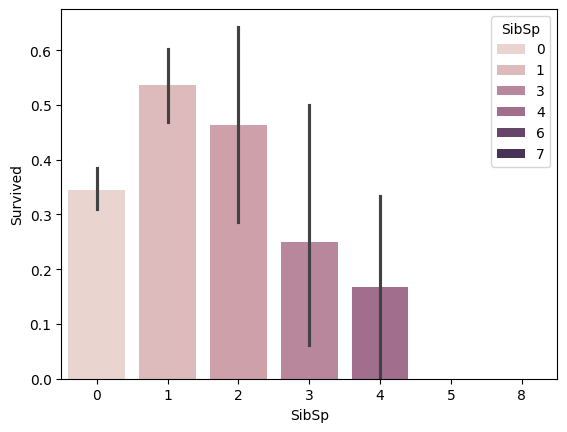

In [16]:
sns.barplot(data=df_train, x='SibSp', y='Survived', hue='SibSp')
plt.show()

**Observations**

There is a high likelihood to survive for a passenger who is alone or with only one extra person.

5. **Parch**

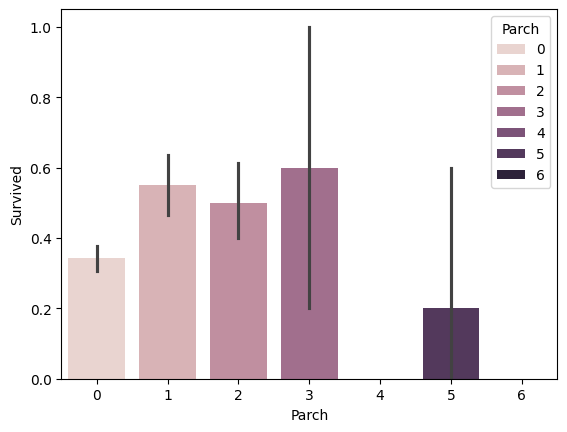

In [17]:
sns.barplot(data=df_train, x='Parch', y='Survived', hue='Parch')
plt.show()

**Observation**

Passengers with parent child relationship were more likely to survive.

6. **Ticket**

Only 210 tickets are shared among the passengers giving the impression that less could be got from the Ticket feature.

7. **Fare**

There are fares which are zero which is not factual. This notebook will impute them using Pclass means.

In [18]:
df_train[['Fare', 'Pclass']][df_train['Fare'] == 0]

,Fare,Pclass
179,0.0,3
263,0.0,1
271,0.0,3
277,0.0,2
302,0.0,3
413,0.0,2
466,0.0,2
481,0.0,2
597,0.0,3
633,0.0,1


In [19]:
pclass_mean1 = round(df_train['Fare'][df_train['Pclass'] == 1].mean(), 4)
pclass_mean2 = round(df_train['Fare'][df_train['Pclass'] == 2].mean(), 4)
pclass_mean3 = round(df_train['Fare'][df_train['Pclass'] == 3].mean(), 4)
print(f'Mean 1: {pclass_mean1}, Mean 2: {pclass_mean2}, Mean : {pclass_mean3}')

Mean 1: 84.1547, Mean 2: 20.6622, Mean : 13.6756


In [20]:
df_train['Fare'][(df_train['Pclass'] == 1) & (df_train['Fare'] == 0)] = pclass_mean1
df_train['Fare'][(df_train['Pclass'] == 2) & (df_train['Fare'] == 0)] = pclass_mean2
df_train['Fare'][(df_train['Pclass'] == 3) & (df_train['Fare'] == 0)] = pclass_mean3

<ipython-input-20-fc72fd6d1b7b>:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_train['Fare'][(df_train['Pclass'] == 1) & (df_train['Fare'] == 0)] = pclass_mean1
<ipython-input-20-fc72fd6d1b7b>:1: SettingWithCopyWarning: 
A value is tryi

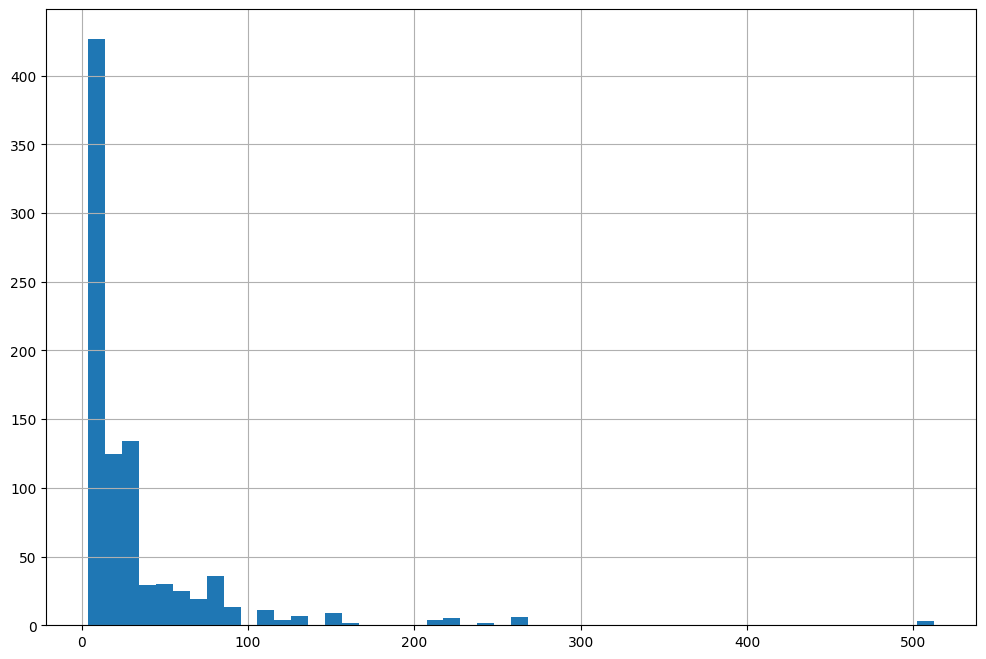

In [21]:
df_train['Fare'].hist(bins=50, figsize=(12, 8))
plt.show()

Due to the disparity of the fare this notebook will create **FareGroup** feature as classified as:

0-40 -> Low(1)

41-100 -> Mid(2)

101-200 -> High(3)

201-500+ -> V.High(4)

In [22]:
df_train['FareGroup'] = pd.cut(df_train['Fare'], bins = [0, 41, 101, 201, np.inf], labels=[1, 2, 3, 4]).astype(int)
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Sex_male,AgeGroup,FareGroup
0,1,0,3,male,22.0,1,0,7.2500,True,Youth,1
1,2,1,1,female,38.0,1,0,71.2833,False,Adult,2
2,3,1,3,female,26.0,0,0,7.9250,False,Youth,1
3,4,1,1,female,35.0,1,0,53.1000,False,Youth,2
4,5,0,3,male,35.0,0,0,8.0500,True,Youth,1




9. **Name**

In [23]:
# Funtion to take the dataframe and feature, pick the title and return a list of the titles
def titling(X, attrib):
    titles = []
    for i in range(len(X)):
        titles.append(str(df_train[attrib][i]).split('.')[0].split(',')[1].strip(' '))

    return titles

**Observations**

From the plot above there is a classification of title and their survival rate. Royal titles had a good survival rate. Common titles had a fair chance of survival and lowest level had the poorest chance in survival.

Classes for the titles will be:

[Master, Major, Lady, Sir, Col, the Countess] -> Royal(1)

[Mr, Mrs, Miss, Dr, Mme, Ms, Mlle] -> Common(2)

[Don, Rev, Capt, Jonkheer] -> Low(3)

This notebook will use label encoding.

In [24]:
def tilgrouping(X, attrib):
    royal = ['Master', 'Major', 'Lady', 'Sir', 'Col', 'the Countess']
    common = ['Mr', 'Mrs', 'Miss', 'Dr', 'Mme', 'Ms', 'Mlle']
    low = ['Don', 'Rev', 'Capt', 'Jonkheer']

    titleg = []

    for i in range(len(X[attrib])):
        if (X[attrib][i]) in royal:
            titleg.append(1)
        elif (X[attrib][i]) in common:
            titleg.append(2)
        elif (X[attrib][i]) in low:
            titleg.append(3)

    return titleg

10. **Family Size and Family Type**

The Family Size and Family type are features engineered from _SibSp_ and _Parch_ features which singly have different effects on survival and this notebook wants to explore if they are combine what their effect is.

In [25]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch']
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Sex_male,AgeGroup,FareGroup,FamilySize
0,1,0,3,male,22.0,1,0,7.2500,True,Youth,1,1
1,2,1,1,female,38.0,1,0,71.2833,False,Adult,2,1
2,3,1,3,female,26.0,0,0,7.9250,False,Youth,1,0
3,4,1,1,female,35.0,1,0,53.1000,False,Youth,2,1
4,5,0,3,male,35.0,0,0,8.0500,True,Youth,1,0


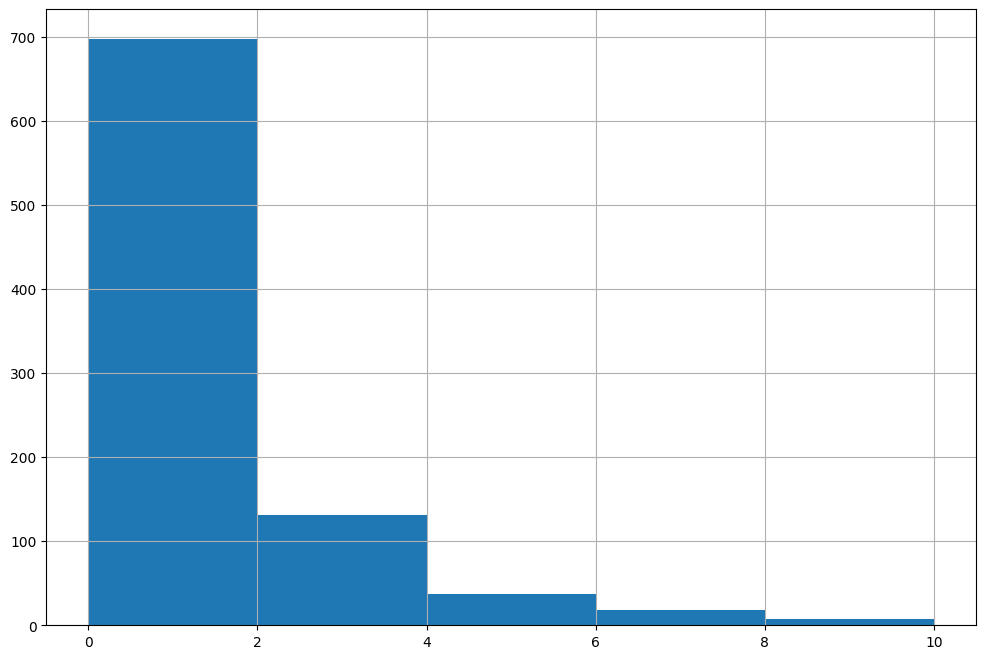

In [26]:
df_train['FamilySize'].hist(bins =5, figsize=(12, 8))
plt.show()

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(df_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
                                                                 'Fare', 'AgeGroup', 'FareGroup']], df_train[['Survived']], test_size=0.3, random_state=42)

#### **One Hot Encoding**

In [28]:
dummies = pd.get_dummies(X_train[['Sex', 'AgeGroup']], drop_first=True)
inputs = pd.concat([X_train.drop(['Sex', 'AgeGroup'], axis=1), dummies], axis=1)

In [29]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [30]:
le.fit(inputs['Pclass'])
inputs['Pclass'] = le.transform(inputs['Pclass'])

#### Testing Different Models

This notebook will try and test the following models:

1. Random Forest
2. LightGBM
3. SVC
4. KNN
5. AdaBoost

6. CatBoost

From the 6 the best will then be selected to be used to predict survival of passengers in the test dataset

In [31]:
!pip install catboost

In [32]:
!pip install --upgrade numpy
!pip install --upgrade --force-reinstall catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 44.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
  Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.

In [32]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier

In [33]:
def display_scores(scores):
    print('Scores: ', scores)
    print('Mean Score:', scores.mean())
    print('Std: ', scores.std())

3. Random Forest

In [34]:
rf_cls = RandomForestClassifier()

scores_rf = cross_val_score(rf_cls, inputs, y_train.values.ravel(), scoring='accuracy', cv=10)
display_scores(scores_rf)

Scores:  [0.84126984 0.80952381 0.84126984 0.80645161 0.83870968 0.77419355
 0.79032258 0.77419355 0.79032258 0.82258065]
Mean Score: 0.8088837685611878
Std:  0.02505411714176898


4. LightGBM

In [35]:
lgb_cls = LGBMClassifier()

scores_lgb = cross_val_score(lgb_cls, inputs, y_train.values.ravel(), scoring='accuracy', cv=10)
display_scores(scores_lgb)

[LightGBM] [Info] Number of positive: 207, number of negative: 353
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 560, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369643 -> initscore=-0.533749
[LightGBM] [Info] Start training from score -0.533749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

5. AdaBoost

In [36]:
from sklearn.impute import SimpleImputer

# Create an imputer to replace NaN values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both training and validation data
inputs = pd.DataFrame(imputer.fit_transform(inputs), columns=inputs.columns)

# Now you can perform cross-validation with the imputed data
ada_cls = AdaBoostClassifier()
scores_ada = cross_val_score(ada_cls, inputs, y_train.values.ravel(), scoring='accuracy', cv=10)
display_scores(scores_ada)

Scores:  [0.73015873 0.77777778 0.93650794 0.87096774 0.77419355 0.70967742
 0.80645161 0.79032258 0.77419355 0.90322581]
Mean Score: 0.807347670250896
Std:  0.06984521602340445


6. CatBoost

In [37]:
# Convert 'Sex' and 'AgeGroup' to string type before getting their locations
X_train['Sex'] = X_train['Sex'].astype(str)
X_train['AgeGroup'] = X_train['AgeGroup'].astype(str)

# Now get the cat_features
cat_features = [X_train.columns.get_loc(col) for col in ['Sex', 'AgeGroup'] if col in X_train.columns]

# Instantiate the CatBoostClassifier
cat_cls = CatBoostClassifier(iterations=2500, learning_rate=0.05, random_seed=42, cat_features=cat_features, verbose=False)

# Perform cross-validation
scores_cat = cross_val_score(cat_cls, X_train, y_train.values.ravel(), scoring='accuracy', cv=10)

In [38]:
display_scores(scores_cat)

Scores:  [0.84126984 0.82539683 0.84126984 0.87096774 0.80645161 0.70967742
 0.87096774 0.77419355 0.79032258 0.87096774]
Mean Score: 0.8201484895033282
Std:  0.04905146328540354


**Observation**

From little exploration, CatBoost performs the best with very high Test and Train Scores.
This notebook will explore a further exploration by means of hyperparameter tuning via GridSearch to select the best estimator with optimum parameters.

The selected algorithms for hyperparameter tuning are: Random Forest, AdaBoost, LightGBM, and CatBoost

#### Hyperparameter Tuning

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


# Random Forest param Grid
rf_param_grid = {
    'n_estimators': [100, 250, 400,],
    'criterion': ['gini', 'entropy'],
    "min_samples_split":[2,3,10],
    "min_samples_leaf":[1,3,10],
    'max_features': ['sqrt', 'log2'],
    'random_state':[8, 16, 42],
}

lgb_param_grid = {
    'boosting_type ':['gbdt', 'rf', 'goss', 'dart'],
    'learning_rate': [0.025, 0.05, 0.1, 0.2],
    'n_estimators': [100, 250, 400],
    'metric': ['auc', 'average_precision'],
    'random_state':[8, 16, 42],
}

ada_param_grid = {
    'n_estimators': [50, 100, 250],
    'learning_rate': [0.1, 0.5, 1, 1.5],
    'random_state':[8, 16, 42],
}

cat_param_grid = {
    'iterations': [1000, 1600, 2000, 2400],
    'learning_rate': [0.01, 0.03, 0.05],
    'random_state':[8, 16, 42],
}

classifier_param = [rf_param_grid, lgb_param_grid, ada_param_grid]

# Classifiers

classifier = [RandomForestClassifier(), LGBMClassifier(), AdaBoostClassifier()]

In [41]:
cv_result = []
best_estimators = []

for i in range(len(classifier)):
    clf = GridSearchCV(classifier[i], param_grid=classifier_param[i],
                       scoring='accuracy', n_jobs=-1, cv=StratifiedKFold(n_splits=5))
    clf.fit(inputs, y_train.values.ravel())
    cv_result.append(clf.best_score_)
    best_estimators.append(clf.best_estimator_)

[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: gbdt
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: gbdt
[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [42]:
clf2 = GridSearchCV(CatBoostClassifier(cat_features=cat_features, verbose=False), param_grid=cat_param_grid,
                    scoring='accuracy', n_jobs=-1, cv=StratifiedKFold(n_splits=10))
clf2.fit(X_train, y_train.values.ravel())
cv_result.append(clf2.best_score_)
best_estimators.append(clf2.best_estimator_)

In [43]:
result = pd.DataFrame({'Mean Score': cv_result, 'Model': ['Random Forest', 'LightGBM', 'AdaBoost', 'CatBoost']})

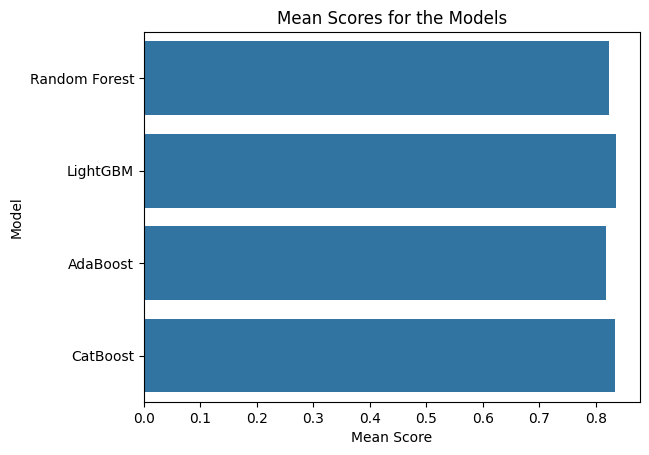

In [44]:
g = sns.barplot(data=result, x='Mean Score', y='Model')
g.set_xlabel('Mean Score')
g.set_title('Mean Scores for the Models')
plt.show()

In [45]:
rf_model = best_estimators[0]
lgb_model= best_estimators[1]
ada_model = best_estimators[2]
cat_model = best_estimators[3]

#### Validate the Models

In [46]:
dummies_ = pd.get_dummies(X_valid[['Sex',  'AgeGroup']], drop_first=True)
inputs_valid = pd.concat([X_valid.drop(['Sex', 'AgeGroup'], axis=1), dummies_], axis=1)

In [48]:
inputs_valid['Pclass'] =le.transform(inputs_valid['Pclass'])
inputs_valid.head()

,Pclass,Age,SibSp,Parch,Fare,FareGroup,Sex_male,AgeGroup_Child,AgeGroup_Youth,AgeGroup_Adult,AgeGroup_Senior
709,2,NaN,1,1,15.2458,1,True,False,False,False,False
439,1,31.0,0,0,10.5000,1,True,False,True,False,False
840,2,20.0,0,0,7.9250,1,True,False,True,False,False
720,1,6.0,0,1,33.0000,1,False,False,False,False,False
39,2,14.0,1,0,11.2417,1,False,True,False,False,False


In [56]:
rf_preds = rf_model.predict(inputs_valid)
lgb_preds = lgb_model.predict(inputs_valid)

rf_acc = accuracy_score(y_valid.values.ravel(), rf_preds)
rf_preds = rf_model.predict(inputs_valid)
lgb_preds = lgb_model.predict(inputs_valid)

rf_acc = accuracy_score(y_valid.values.ravel(), rf_preds)
lgb_acc = accuracy_score(y_valid.values.ravel(), lgb_preds)

print(f'Accuracies -> Random Forest: {rf_acc}, LightGBM: {lgb_acc}')

[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: gbdt
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: gbdt
Accuracies -> Random Forest: 0.8097014925373134, LightGBM: 0.7350746268656716


**Observation**
From the test accuracies(demonstrating prediction on unseen data) the models rank as follows:
1. CatBoost
2. Random Forest
3. LightGBM & AdaBoost

###  **Predict Survival of the Passengers in the Test Data**

###### **Processing Test Data**

In [57]:
X_train.shape

(623, 8)

In [58]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


##### Imputing Missing Values and Feature Engineering in the Test Dataset

In [59]:
data1 = df_test[['Pclass', 'Sex','Age', 'SibSp','Parch', 'Fare']]

In [60]:
data1.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,male,34.5,0,0,7.8292
1,3,female,47.0,1,0,7.0000
2,2,male,62.0,0,0,9.6875
3,3,male,27.0,0,0,8.6625
4,3,female,22.0,1,1,12.2875


In [63]:
# Sex and Embarked Encoding
seencoding = pd.get_dummies(data1[['Sex', 'Pclass']], drop_first=True)
data_tst = pd.concat([data1.drop(['Sex', 'Pclass'], axis=1), seencoding], axis=1)

In [64]:
data_tst.shape

(418, 6)

In [65]:
# Scaling
scaler1 = MinMaxScaler()
tst_fmd = scaler1.fit_transform(data_tst)
data_tst1 = pd.DataFrame(data=tst_fmd, columns=data_tst.columns)

In [ ]:
data_tst1.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,1.0,0.452723,0.000,0.000000,0.015282,1.0,1.0,0.0
1,1.0,0.617566,0.125,0.000000,0.013663,0.0,0.0,1.0
2,0.5,0.815377,0.000,0.000000,0.018909,1.0,1.0,0.0
3,1.0,0.353818,0.000,0.000000,0.016908,1.0,0.0,1.0
4,1.0,0.287881,0.125,0.111111,0.023984,0.0,0.0,1.0


In [66]:
# Imputing Missing Values
data_tst2 = knn_imputer.fit_transform(data_tst1)
data_tst3 = pd.DataFrame(data=data_tst2, columns=data_tst1.columns)
data_tst3.head()

NameError: name 'knn_imputer' is not defined

In [ ]:
data_tst_inv = scaler1.inverse_transform(data_tst3)
data_tst4 = pd.DataFrame(data=data_tst_inv, columns=data_tst3.columns)
data_tst4.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3.0,34.5,0.0,0.0,7.8292,1.0,1.0,0.0
1,3.0,47.0,1.0,0.0,7.0000,0.0,0.0,1.0
2,2.0,62.0,0.0,0.0,9.6875,1.0,1.0,0.0
3,3.0,27.0,0.0,0.0,8.6625,1.0,0.0,1.0
4,3.0,22.0,1.0,1.0,12.2875,0.0,0.0,1.0


In [ ]:
# Recreate the Sex Feature

data_tst4['Sex'] = sexify(data_tst4['Sex_male'])

In [ ]:
# Recreate the Embarked Feature
data_tst4['Embarked'] = embify(data_tst4[['Embarked_Q', 'Embarked_S']])

In [ ]:
test_data = pd.concat([data_tst4[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']], df_test[['PassengerId','FamilyType']]], axis=1)

In [ ]:
test_data.columns, X_train.columns

(Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
        'PassengerId', 'Name'],
       dtype='object'),
 Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
        'AgeGroup', 'FareGroup', 'TitleGroup', 'FamilySize', 'FamilyType'],
       dtype='object'))

In [ ]:
test_data[['Fare', 'Pclass']][test_data['Fare'] == 0]

,Fare,Pclass
266,0.0,1.0
372,0.0,1.0


In [ ]:
pclass_mean1t = round(test_data['Fare'][test_data['Pclass'] == 1.0].mean(), 4)

In [ ]:
test_data['Fare'][(test_data['Fare'] == 0) & (test_data['Pclass'] == 1)] =pclass_mean1t

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_data['AgeGroup'] = pd.cut(test_data['Age'], bins = bins, labels = labels)

In [ ]:
test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,PassengerId,Name,AgeGroup
0,3.0,male,34.5,0.0,0.0,7.8292,Q,892,"Kelly, Mr. James",Youth
1,3.0,female,47.0,1.0,0.0,7.0000,S,893,"Wilkes, Mrs. James (Ellen Needs)",Adult
2,2.0,male,62.0,0.0,0.0,9.6875,Q,894,"Myles, Mr. Thomas Francis",Senior
3,3.0,male,27.0,0.0,0.0,8.6625,S,895,"Wirz, Mr. Albert",Youth
4,3.0,female,22.0,1.0,1.0,12.2875,S,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",Youth


In [ ]:
test_data['FareGroup'] = pd.cut(test_data['Fare'], bins = [0, 41, 101, 201, np.inf], labels=[1, 2, 3, 4]).astype(int)

In [ ]:
test_data['Title'] = titling(test_data, 'FamilyType')

In [ ]:
test_data['TitleGroup'] = tilgrouping(test_data, 'Title')

In [ ]:
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch']
test_data['FamilyType'] = pd.cut(test_data['FamilySize'], bins=[-1, 0.5, 4, np.inf], labels=['Alone', 'Small', 'Big'])

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Pclass       418 non-null    float64 
 1   Sex          418 non-null    object  
 2   Age          418 non-null    float64 
 3   SibSp        418 non-null    float64 
 4   Parch        418 non-null    float64 
 5   Fare         418 non-null    float64 
 6   Embarked     418 non-null    object  
 7   PassengerId  418 non-null    int64   
 8   Name         418 non-null    object  
 9   AgeGroup     418 non-null    category
 10  FareGroup    418 non-null    int64   
 11  Title        418 non-null    object  
 12  TitleGroup   418 non-null    int64   
 13  FamilySize   418 non-null    float64 
 14  FamilyType   418 non-null    category
dtypes: category(2), float64(6), int64(3), object(4)
memory usage: 43.7+ KB


In [ ]:
test_data.to_csv('/content/drive/MyDrive/MLData/Titanic/Prepd_Titanic_test_data.csv',index=False)

In [ ]:
test_preds = cat_model.predict(test_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'AgeGroup', 'FareGroup', 'TitleGroup', 'FamilySize', 'FamilyType']])

In [ ]:
survival_results = pd.concat([df_test['PassengerId'], pd.Series(test_preds, name='Survived')], axis=1)

In [ ]:
survival_results.to_csv('survived_submission.csv', index=False)

### **Saving the Model(s)**

In [ ]:
import joblib
import os

In [ ]:
path = '/content/drive/MyDrive/MLData/Titanic'
filenames =  ['Titanic_CatBoost_model.joblib', 'Titanic_LightGBM_model.joblib', 'Titanic_RF_model.joblib','Titanic_Ada_model.joblib']
models = [cat_model, lgb_model, rf_model, ada_model]

for i in range(len(filenames)):
  joblib.dump(models[i], os.path.join(path, filenames[i]))